In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [2]:
# traintime, infertime, validmse, validmae, testmse, testmae
results = {
    'MLP': [47.99, 0.2663, 9.67, 1.73, 22.05, 2.82],
    'LGBM': [21.08, 0.0751, 6.61, 1.28, 25.40, 2.69],
    'XGB': [144.91, 0.1105, 6.38, 1.18, 22.31, 2.40],
    'CB': [150.89, 1.2647, 6.89, 1.27, 24.61, 2.58],
    'GRU': [354.75, 12.2085, 12.66, 1.93, 28.42, 2.77],
    'LSTM': [362.20, 12.2351, 12.25, 1.86, 28.18, 2.77],
    'LR': [4.03, 0.0068, 6.66, 1.26, 9.05, 1.48]
}

In [3]:
results_df = pd.DataFrame(results)
results_df.index = ['Train Length (sec)', 'Inference Length (sec)', 'Valid MSE',
                    'Valid MAE', 'Test MSE', 'Test MAE']

coldict = {'LR':'thistle'}
def highlight_cols(s, coldict):
    if s.name in coldict.keys():
        return ['background-color: {}'.format(coldict[s.name])] * len(s)
    return [''] * len(s)
results_df.style.apply(highlight_cols, coldict=coldict)

From the above results, we can see that the Linear Regression model is the clear winner in this competition. Thus, it will be used for inference.

# Inference

We can make predictions for only the next timestep (day) or for multiple days. If the latter is the case, then we will be iteratively producing predictions for the next day and then use these predictions as inputs to predict the next values. This procedure is known as auto-regression.

In [4]:
# last values we have for all ids
last_values = np.load('test_np.npy')[:, 2:][-272:]

In [5]:
def generate_preds(last_values, period=1):
    '''
    Inputs:
        last_values: the last 365 values for the time-series
        period: number of days to generate predictions for
    Returns:
        all_preds: the generated predictions
        last_values: the last 365 values for the time-series after adding the predictions
    '''
    if len(last_values.shape) == 1:
        last_values = np.expand_dims(last_values, axis=0)
    model = pickle.load(open('lr_model.pkl', 'rb'))
    all_preds = np.zeros((len(last_values), 1))
    for i in range(period):
        preds = model.predict(last_values)
        last_values = np.c_[last_values, preds]
        last_values = last_values[:, -365:]
        if i == 0:
            all_preds[:, 0] = preds
        else:
            all_preds = np.c_[all_preds, preds]
    return all_preds, last_values

In [6]:
%%time
all_preds, last_values = generate_preds(last_values, 30)

CPU times: user 640 ms, sys: 201 ms, total: 841 ms
Wall time: 8.81 s


# Visualize Predictions

In [7]:
ids = np.unique(np.load('test_np.npy')[:, 0].astype(int))

def plot_results(all_preds):
    '''
    Inputs: 
        all_preds: np array (predicted values) 
    Returns:
        plots all_preds
    '''
    plt.figure(figsize=(6*3, 4*91))
    for i in tqdm(range(0, 272), total=272):
        plt.subplot(91, 3, i+1)
        plt.plot(all_preds[i, :])
        plt.title(ids[i])
        plt.grid(alpha=1, linestyle='-.')
        plt.ylabel('Consumption')
    plt.show()

  0%|          | 0/272 [00:00<?, ?it/s]

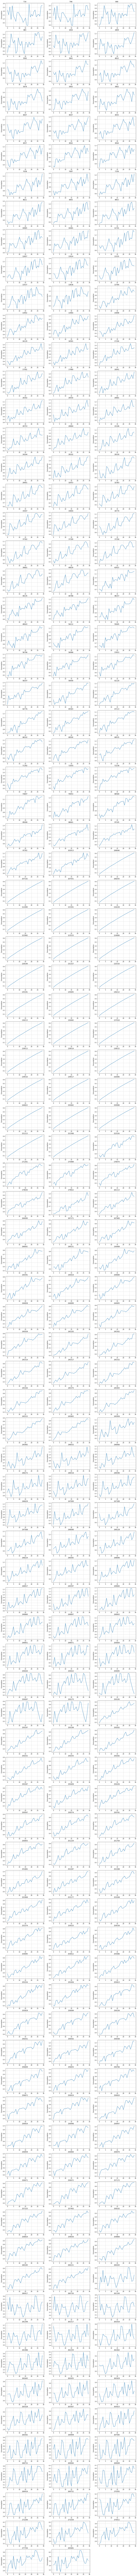

In [8]:
plot_results(all_preds)